[ 2  4  6  8 10 12 14 16 18 20]
[13.322285425447397, 11.687141263435882, 10.618318937120149, 9.84383102605773, 9.246570641875588, 8.766285160898198, 8.368239809916, 8.030751383861318, 7.739460374972272, 7.484412740563223]
[214.91611638270447, 173.85552393769262, 149.34970039815005, 132.7452417571094, 120.59842307645816, 111.24339113498914, 103.76715081788043, 97.62359715562822, 92.46417483032874, 88.05496548311518]
Expected value of first hitting times:  15.509653999999983
Variance of first hitting times:  279.373949975198
Variance of first hitting times: 279.37394456094347
p_3 = 2.0, Empirical Expectation = 14.0926
p_3 = 2.0, Empirical Variance = 232.0549
p_3 = 4.0, Empirical Expectation = 12.3622
p_3 = 4.0, Empirical Variance = 190.6151
p_3 = 6.0, Empirical Expectation = 11.4491
p_3 = 6.0, Empirical Variance = 170.1594
p_3 = 8.0, Empirical Expectation = 10.4739
p_3 = 8.0, Empirical Variance = 147.4424
p_3 = 10.0, Empirical Expectation = 9.8908
p_3 = 10.0, Empirical Variance = 135.283

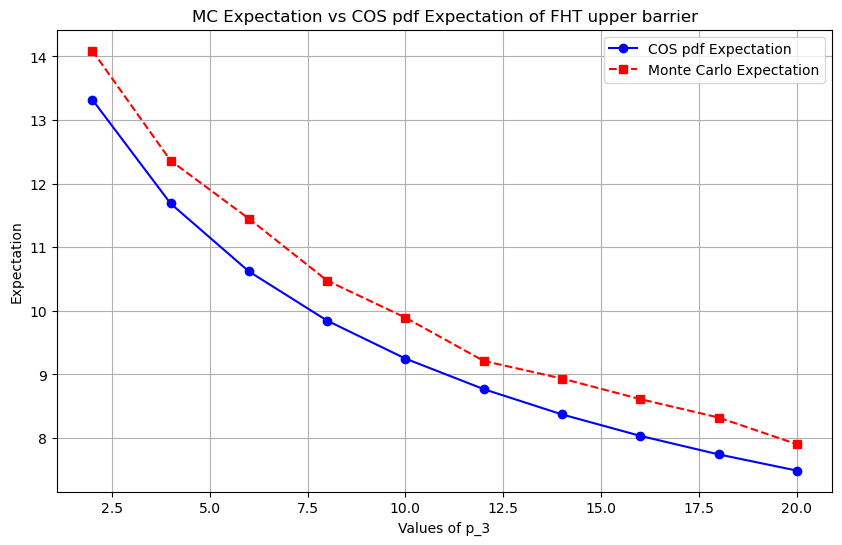

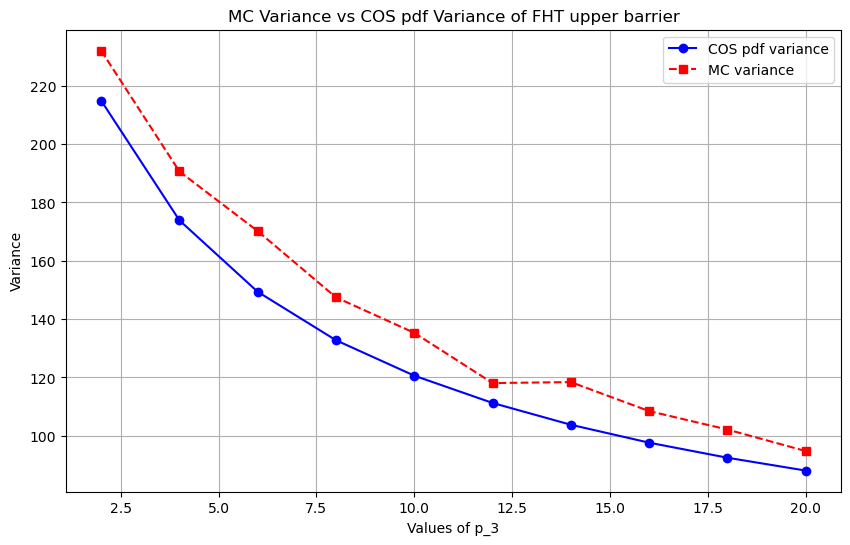

In [39]:
# testing positive values of p_3 for expectation and variance for upper barrier



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.35
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = 1  # Initial value, will be changed
p_2 = 0.5
p_3 = 1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used

"""
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p3):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / p_1
    elif degree == 2:
        return 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*current_p3))
        q = p**3 + (p_2*p_1 - 3*current_p3*(p_0-x)) / (6*current_p3**2)
        r = p_1/(3*current_p3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p3, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - inv_poly(a, degree, current_p3)) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*(inv_poly(a, degree, current_p3) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def expectation_variance():
    p_3_values = np.arange(2, 22, 2)
    expectation = []
    variance = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_3_values:
        # Create a phi function bound to the current p_3 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        expect = np.trapz(x*f_X, x)
        expectation.append(expect)
        E_x2 = np.trapz(x**2*f_X, x)
        var = E_x2 - expect**2
        variance.append(var)
        

    return p_3_values, expectation, variance

p_3_values, COS_expectation, COS_variance = expectation_variance()
print(p_3_values)
print(COS_expectation)
print(COS_variance)
    


T = 150                                # simulation length
m = 15000                                 # number of timepoints
time_points = np.linspace(0, T, m + 1)  # time grid

def inv_poly(x,degree):
    if degree == 1:
        inv = (x- p_0) / p_1
    elif degree == 2:
        inv = 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        inv = p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))
    return inv


def simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths,p_0, p_1, p_2, p_3):
    dt = T / m

    #initialize paths
    OU_paths = np.zeros((n_paths, m + 1))
    POLY_OU_paths = np.zeros((n_paths, m + 1))
    OU_paths[:,0] = x_0
    POLY_OU_paths[:, 0] =  p_0 + p_1 * x_0 + p_2 * x_0**2 + p_3 * x_0**3

    # Generate all random shocks upfront (size: n_paths × m)
    dW = np.sqrt(dt) * np.random.normal(0, 1, size=(n_paths, m))
    
    for j in range(m):
        OU_next = OU_paths[:, j] + theta * (mu - OU_paths[:, j]) * dt + sigma * dW[:, j]
        OU_paths[:, j + 1] = OU_next
        POLY_OU_paths[:, j + 1] = p_0 + p_1 * OU_next + p_2 * OU_next**2 + p_3 * OU_next**3
    
    return POLY_OU_paths, OU_paths 


# Simulate multiple paths
n_paths = 20000


poly_ou_paths, ou_paths = simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths, p_0, p_1, p_2, p_3)

def compute_first_hitting_times(paths, b, n_paths):
    hitting_times = []
    
    for i in range(n_paths):
        hit_index = []
        for j in range (m):
            if paths[i, j] >= a:
                hit_index.append((j/m)*T)
        if len(hit_index) > 0:
            hitting_times.append(hit_index[0])  # Store first hitting time
        
    return np.array(hitting_times)

# Compute first hitting times
hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)

#computing average first hitting time
expected_value = sum(hitting_times)/ n_paths
print("Expected value of first hitting times: ", expected_value)

#computing variance of first hitting time
variance = sum((hitting_times - expected_value) ** 2) / (len(hitting_times) - 1)

print("Variance of first hitting times: ", variance)

variance = np.var(hitting_times, ddof=1)  # Using ddof=1 for sample variance
print("Variance of first hitting times:", variance)

"""
# Plot first 5 OU paths and their polynomial transforms
plt.figure(figsize=(14, 7))

for i in range(min(5, n_paths)):
    plt.plot(time_points, ou_paths[i], 'b-', alpha=0.6, label='OU Process' if i == 0 else "")
    plt.plot(time_points, poly_ou_paths[i], 'r--', alpha=0.6, label='Polynomial Process' if i == 0 else "")

plt.axhline(a, color='k', linestyle='--', label=f'Barrier at {a}')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("OU Process vs. Polynomial Transformation (First 5 Paths)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Histogram of hitting times (if any paths hit the barrier)
if len(hitting_times) > 0:
    plt.figure(figsize=(10, 5))
    plt.hist(hitting_times, bins=120, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("First Hitting Time")
    plt.ylabel("Density")
    plt.title(f"First Hitting Times for Barrier = {a}")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print("No paths hit the barrier; no histogram generated.")
"""
# Reuse these values
p_3_values = np.arange(2, 22, 2)  # Skip 0 to avoid division errors
MC_expectation = []
MC_variance = []

for p3 in p_3_values:
    poly_ou_paths, ou_paths = simulate_POLY_OU_process(
        theta, mu, sigma, x_0, T, m, n_paths,
        p_0, p_1, p_2, p3
    )
    
    hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)
    
    if len(hitting_times) > 0:
        expected_value = np.mean(hitting_times)
    else:
        expected_value = np.nan  # In case no paths hit the barrier
    
    MC_expectation.append(expected_value)
    print(f"p_3 = {p3:.1f}, Empirical Expectation = {expected_value:.4f}")
    if len(hitting_times) > 0:
        variance = np.var(hitting_times, ddof=1)
    else:
        variance = np.nan  # In case no paths hit the barrier
    
    
    MC_variance.append(variance)
    print(f"p_3 = {p3:.1f}, Empirical Variance = {variance:.4f}")



plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_expectation, 'b-o', label='COS pdf Expectation')
plt.plot(p_3_values, MC_expectation, 'r--s', label='Monte Carlo Expectation')
plt.xlabel("Values of p_3")
plt.ylabel("Expectation")
plt.title("MC Expectation vs COS pdf Expectation of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_variance, 'b-o', label='COS pdf variance')
plt.plot(p_3_values, MC_variance, 'r--s', label='MC variance')
plt.xlabel("Values of p_3")
plt.ylabel("Variance")
plt.title("MC Variance vs COS pdf Variance of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()



[ 2  4  6  8 10 12 14 16 18 20]
[19.705076898782558, 15.233919365379027, 13.034525488408109, 11.659243466741346, 10.692073459400838, 9.962395012804784, 9.385476757859934, 8.913791048272083, 8.518314409038979, 8.180172971291018]
[414.0840267451713, 268.30759630215937, 207.37850258040368, 173.1923946111014, 150.98139164856553, 135.22456747938833, 123.37251491845463, 114.0775310090303, 106.55654909883894, 100.32160124398825]
Expected value of first hitting times:  0.0
Variance of first hitting times:  0.0
Variance of first hitting times: 0.0
p_3 = 2.0, Empirical Expectation = 20.6321
p_3 = 2.0, Empirical Variance = 443.0438
p_3 = 4.0, Empirical Expectation = 15.8975
p_3 = 4.0, Empirical Variance = 287.0720
p_3 = 6.0, Empirical Expectation = 13.6433
p_3 = 6.0, Empirical Variance = 219.3768
p_3 = 8.0, Empirical Expectation = 12.3391
p_3 = 8.0, Empirical Variance = 190.3293
p_3 = 10.0, Empirical Expectation = 11.1512
p_3 = 10.0, Empirical Variance = 160.4128
p_3 = 12.0, Empirical Expectation

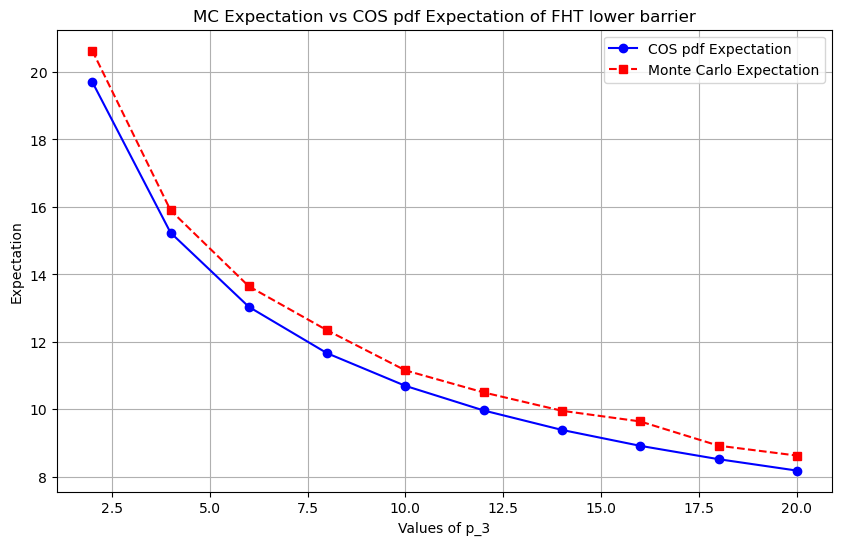

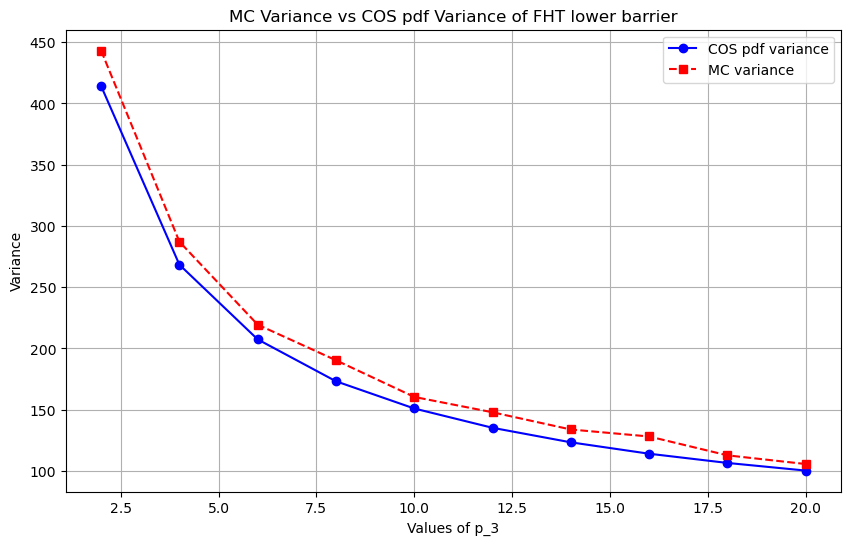

In [40]:
# testing positive values of p_3 for expectation and variance for lower barrier



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = 1  # Initial value, will be changed
p_2 = 0.5
p_3 = 0.5
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used

b = 1.65
"""
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p3):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / p_1
    elif degree == 2:
        return 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*current_p3))
        q = p**3 + (p_2*p_1 - 3*current_p3*(p_0-x)) / (6*current_p3**2)
        r = p_1/(3*current_p3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p3, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - (2*x_0 - inv_poly(b, degree, current_p3))) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*((2*x_0 - inv_poly(b, degree, current_p3)) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def expectation_variance():
    p_3_values = np.arange(2, 22, 2)
    expectation = []
    variance = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_3_values:
        # Create a phi function bound to the current p_3 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        expect = np.trapz(x*f_X, x)
        expectation.append(expect)
        E_x2 = np.trapz(x**2*f_X, x)
        var = E_x2 - expect**2
        variance.append(var)
        

    return p_3_values, expectation, variance

p_3_values, COS_expectation, COS_variance = expectation_variance()
print(p_3_values)
print(COS_expectation)
print(COS_variance)
    


T = 150                                # simulation length
m = 15000                                 # number of timepoints
time_points = np.linspace(0, T, m + 1)  # time grid

def inv_poly(x,degree):
    if degree == 1:
        inv = (x- p_0) / p_1
    elif degree == 2:
        inv = 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        inv = p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))
    return inv


def simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths,p_0, p_1, p_2, p_3):
    dt = T / m

    #initialize paths
    OU_paths = np.zeros((n_paths, m + 1))
    POLY_OU_paths = np.zeros((n_paths, m + 1))
    OU_paths[:,0] = x_0
    POLY_OU_paths[:, 0] =  p_0 + p_1 * x_0 + p_2 * x_0**2 + p_3 * x_0**3

    # Generate all random shocks upfront (size: n_paths × m)
    dW = np.sqrt(dt) * np.random.normal(0, 1, size=(n_paths, m))
    
    for j in range(m):
        OU_next = OU_paths[:, j] + theta * (mu - OU_paths[:, j]) * dt + sigma * dW[:, j]
        OU_paths[:, j + 1] = OU_next
        POLY_OU_paths[:, j + 1] = p_0 + p_1 * OU_next + p_2 * OU_next**2 + p_3 * OU_next**3
    
    return POLY_OU_paths, OU_paths 


# Simulate multiple paths
n_paths = 20000


poly_ou_paths, ou_paths = simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths, p_0, p_1, p_2, p_3)

def compute_first_hitting_times(paths, b, n_paths):
    hitting_times = []
    
    for i in range(n_paths):
        hit_index = []
        for j in range (m):
            if paths[i, j] <= b:
                hit_index.append((j/m)*T)
        if len(hit_index) > 0:
            hitting_times.append(hit_index[0])  # Store first hitting time
        
    return np.array(hitting_times)

# Compute first hitting times
hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)

#computing average first hitting time
expected_value = sum(hitting_times)/ n_paths
print("Expected value of first hitting times: ", expected_value)

#computing variance of first hitting time
variance = sum((hitting_times - expected_value) ** 2) / (len(hitting_times) - 1)

print("Variance of first hitting times: ", variance)

variance = np.var(hitting_times, ddof=1)  # Using ddof=1 for sample variance
print("Variance of first hitting times:", variance)

"""
# Plot first 5 OU paths and their polynomial transforms
plt.figure(figsize=(14, 7))

for i in range(min(5, n_paths)):
    plt.plot(time_points, ou_paths[i], 'b-', alpha=0.6, label='OU Process' if i == 0 else "")
    plt.plot(time_points, poly_ou_paths[i], 'r--', alpha=0.6, label='Polynomial Process' if i == 0 else "")

plt.axhline(a, color='k', linestyle='--', label=f'Barrier at {a}')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("OU Process vs. Polynomial Transformation (First 5 Paths)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Histogram of hitting times (if any paths hit the barrier)
if len(hitting_times) > 0:
    plt.figure(figsize=(10, 5))
    plt.hist(hitting_times, bins=120, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("First Hitting Time")
    plt.ylabel("Density")
    plt.title(f"First Hitting Times for Barrier = {a}")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print("No paths hit the barrier; no histogram generated.")
"""
# Reuse these values
p_3_values = np.arange(2, 22, 2)  # Skip 0 to avoid division errors
MC_expectation = []
MC_variance = []

for p3 in p_3_values:
    poly_ou_paths, ou_paths = simulate_POLY_OU_process(
        theta, mu, sigma, x_0, T, m, n_paths,
        p_0, p_1, p_2, p3
    )
    
    hitting_times = compute_first_hitting_times(poly_ou_paths, b, n_paths)
    
    if len(hitting_times) > 0:
        expected_value = np.mean(hitting_times)
    else:
        expected_value = np.nan  # In case no paths hit the barrier
    
    MC_expectation.append(expected_value)
    print(f"p_3 = {p3:.1f}, Empirical Expectation = {expected_value:.4f}")
    if len(hitting_times) > 0:
        variance = np.var(hitting_times, ddof=1)
    else:
        variance = np.nan  # In case no paths hit the barrier
    
    
    MC_variance.append(variance)
    print(f"p_3 = {p3:.1f}, Empirical Variance = {variance:.4f}")



plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_expectation, 'b-o', label='COS pdf Expectation')
plt.plot(p_3_values, MC_expectation, 'r--s', label='Monte Carlo Expectation')
plt.xlabel("Values of p_3")
plt.ylabel("Expectation")
plt.title("MC Expectation vs COS pdf Expectation of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_variance, 'b-o', label='COS pdf variance')
plt.plot(p_3_values, MC_variance, 'r--s', label='MC variance')
plt.xlabel("Values of p_3")
plt.ylabel("Variance")
plt.title("MC Variance vs COS pdf Variance of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()



[-20 -18 -16 -14 -12 -10  -8  -6  -4  -2]
[7.484412740563223, 7.739460374972272, 8.030751383861318, 8.368239809916, 8.766285160898198, 9.246570641875588, 9.84383102605773, 10.618318937120149, 11.687141263435882, 13.322285425447397]
[88.05496548311518, 92.46417483032874, 97.62359715562822, 103.76715081788043, 111.24339113498914, 120.59842307645816, 132.7452417571094, 149.34970039815005, 173.85552393769262, 214.91611638270447]
Expected value of first hitting times:  15.180465499999988
Variance of first hitting times:  261.10504001639373
Variance of first hitting times: 261.1050348295313
p_3 = -20.0, Empirical Expectation = 8.0415
p_3 = -20.0, Empirical Variance = 98.9158
p_3 = -18.0, Empirical Expectation = 8.2008
p_3 = -18.0, Empirical Variance = 100.6201
p_3 = -16.0, Empirical Expectation = 8.5823
p_3 = -16.0, Empirical Variance = 106.5250
p_3 = -14.0, Empirical Expectation = 8.8834
p_3 = -14.0, Empirical Variance = 113.6201
p_3 = -12.0, Empirical Expectation = 9.2969
p_3 = -12.0, Empi

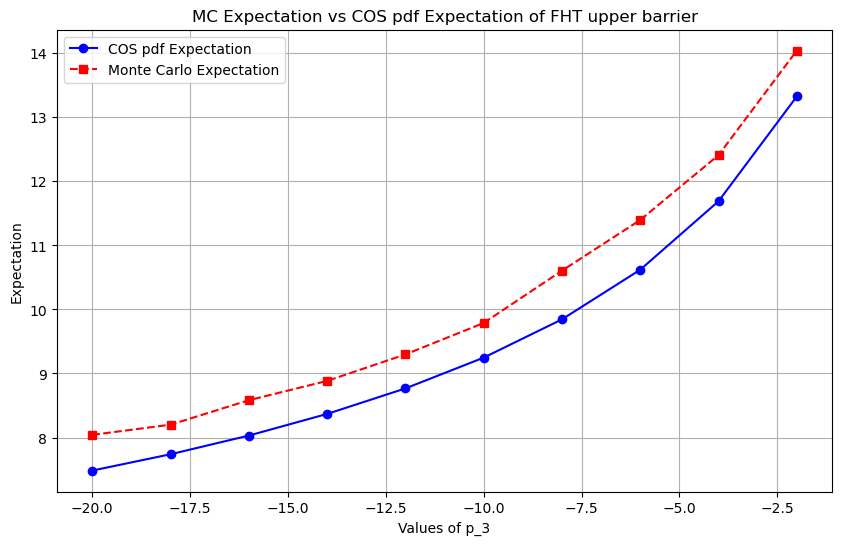

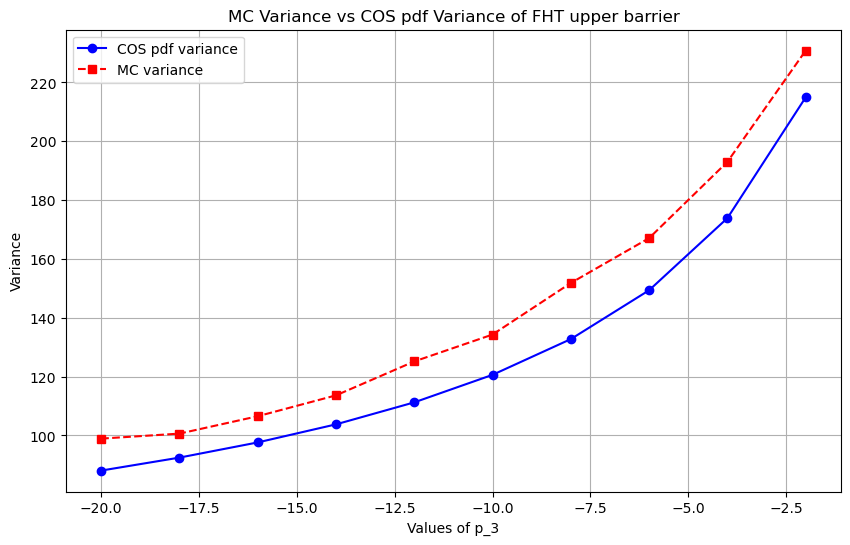

In [41]:
# testing negative values of p_3 for expectation and variance for upper barrier



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.35
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = -1  # Initial value, will be changed
p_2 = 0.5
p_3 = -1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used

"""
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p3):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / p_1
    elif degree == 2:
        return 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*current_p3))
        q = p**3 + (p_2*p_1 - 3*current_p3*(p_0-x)) / (6*current_p3**2)
        r = p_1/(3*current_p3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p3, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - (2*x_0 - inv_poly(a, degree, current_p3))) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*((2*x_0 - inv_poly(a, degree, current_p3)) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def expectation_variance():
    p_3_values = np.arange(-20, 0, 2)
    expectation = []
    variance = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_3_values:
        # Create a phi function bound to the current p_3 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        expect = np.trapz(x*f_X, x)
        expectation.append(expect)
        E_x2 = np.trapz(x**2*f_X, x)
        var = E_x2 - expect**2
        variance.append(var)
        

    return p_3_values, expectation, variance

p_3_values, COS_expectation, COS_variance = expectation_variance()
print(p_3_values)
print(COS_expectation)
print(COS_variance)
    


T = 150                                # simulation length
m = 15000                                 # number of timepoints
time_points = np.linspace(0, T, m + 1)  # time grid

def inv_poly(x,degree):
    if degree == 1:
        inv = (x- p_0) / p_1
    elif degree == 2:
        inv = 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        inv = p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))
    return inv


def simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths,p_0, p_1, p_2, p_3):
    dt = T / m

    #initialize paths
    OU_paths = np.zeros((n_paths, m + 1))
    POLY_OU_paths = np.zeros((n_paths, m + 1))
    OU_paths[:,0] = x_0
    POLY_OU_paths[:, 0] =  p_0 + p_1 * x_0 + p_2 * x_0**2 + p_3 * x_0**3

    # Generate all random shocks upfront (size: n_paths × m)
    dW = np.sqrt(dt) * np.random.normal(0, 1, size=(n_paths, m))
    
    for j in range(m):
        OU_next = OU_paths[:, j] + theta * (mu - OU_paths[:, j]) * dt + sigma * dW[:, j]
        OU_paths[:, j + 1] = OU_next
        POLY_OU_paths[:, j + 1] = p_0 + p_1 * OU_next + p_2 * OU_next**2 + p_3 * OU_next**3
    
    return POLY_OU_paths, OU_paths 


# Simulate multiple paths
n_paths = 20000


poly_ou_paths, ou_paths = simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths, p_0, p_1, p_2, p_3)

def compute_first_hitting_times(paths, b, n_paths):
    hitting_times = []
    
    for i in range(n_paths):
        hit_index = []
        for j in range (m):
            if paths[i, j] >= a:
                hit_index.append((j/m)*T)
        if len(hit_index) > 0:
            hitting_times.append(hit_index[0])  # Store first hitting time
        
    return np.array(hitting_times)

# Compute first hitting times
hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)

#computing average first hitting time
expected_value = sum(hitting_times)/ n_paths
print("Expected value of first hitting times: ", expected_value)

#computing variance of first hitting time
variance = sum((hitting_times - expected_value) ** 2) / (len(hitting_times) - 1)

print("Variance of first hitting times: ", variance)

variance = np.var(hitting_times, ddof=1)  # Using ddof=1 for sample variance
print("Variance of first hitting times:", variance)

"""
# Plot first 5 OU paths and their polynomial transforms
plt.figure(figsize=(14, 7))

for i in range(min(5, n_paths)):
    plt.plot(time_points, ou_paths[i], 'b-', alpha=0.6, label='OU Process' if i == 0 else "")
    plt.plot(time_points, poly_ou_paths[i], 'r--', alpha=0.6, label='Polynomial Process' if i == 0 else "")

plt.axhline(a, color='k', linestyle='--', label=f'Barrier at {a}')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("OU Process vs. Polynomial Transformation (First 5 Paths)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Histogram of hitting times (if any paths hit the barrier)
if len(hitting_times) > 0:
    plt.figure(figsize=(10, 5))
    plt.hist(hitting_times, bins=120, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("First Hitting Time")
    plt.ylabel("Density")
    plt.title(f"First Hitting Times for Barrier = {a}")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print("No paths hit the barrier; no histogram generated.")
"""
# Reuse these values
p_3_values = np.arange(-20, 0, 2)  # Skip 0 to avoid division errors
MC_expectation = []
MC_variance = []

for p3 in p_3_values:
    poly_ou_paths, ou_paths = simulate_POLY_OU_process(
        theta, mu, sigma, x_0, T, m, n_paths,
        p_0, p_1, p_2, p3
    )
    
    hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)
    
    if len(hitting_times) > 0:
        expected_value = np.mean(hitting_times)
    else:
        expected_value = np.nan  # In case no paths hit the barrier
    
    MC_expectation.append(expected_value)
    print(f"p_3 = {p3:.1f}, Empirical Expectation = {expected_value:.4f}")
    if len(hitting_times) > 0:
        variance = np.var(hitting_times, ddof=1)
    else:
        variance = np.nan  # In case no paths hit the barrier
    
    
    MC_variance.append(variance)
    print(f"p_3 = {p3:.1f}, Empirical Variance = {variance:.4f}")



plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_expectation, 'b-o', label='COS pdf Expectation')
plt.plot(p_3_values, MC_expectation, 'r--s', label='Monte Carlo Expectation')
plt.xlabel("Values of p_3")
plt.ylabel("Expectation")
plt.title("MC Expectation vs COS pdf Expectation of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_variance, 'b-o', label='COS pdf variance')
plt.plot(p_3_values, MC_variance, 'r--s', label='MC variance')
plt.xlabel("Values of p_3")
plt.ylabel("Variance")
plt.title("MC Variance vs COS pdf Variance of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()



[-20 -18 -16 -14 -12 -10  -8  -6  -4  -2]
[8.180172971291018, 8.518314409038979, 8.913791048272083, 9.385476757859934, 9.962395012804784, 10.692073459400838, 11.659243466741346, 13.034525488408109, 15.233919365379027, 19.705076898782558]
[100.32160124398825, 106.55654909883894, 114.0775310090303, 123.37251491845463, 135.22456747938833, 150.98139164856553, 173.1923946111014, 207.37850258040368, 268.30759630215937, 414.0840267451713]
Expected value of first hitting times:  0.0
Variance of first hitting times:  0.0
Variance of first hitting times: 0.0
p_3 = -20.0, Empirical Expectation = 8.6832
p_3 = -20.0, Empirical Variance = 108.8259
p_3 = -18.0, Empirical Expectation = 9.1693
p_3 = -18.0, Empirical Variance = 120.6335
p_3 = -16.0, Empirical Expectation = 9.4613
p_3 = -16.0, Empirical Variance = 124.5248
p_3 = -14.0, Empirical Expectation = 10.0890
p_3 = -14.0, Empirical Variance = 133.4162
p_3 = -12.0, Empirical Expectation = 10.5961
p_3 = -12.0, Empirical Variance = 147.7558
p_3 = -1

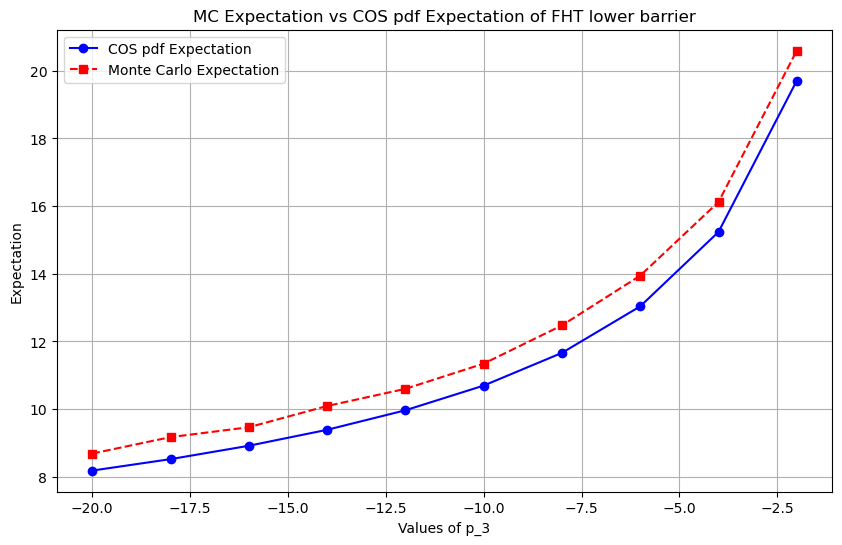

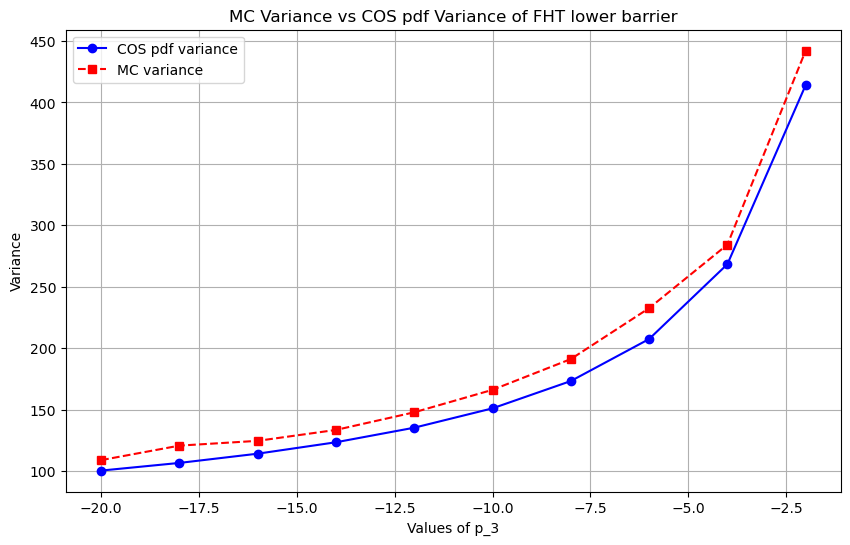

In [42]:
# testing negative values of p_3 for expectation and variance for lower barrier



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = -1  # Initial value, will be changed
p_2 = 0.5
p_3 = -0.5
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used

b = 1.65
"""
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p3):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / p_1
    elif degree == 2:
        return 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*current_p3))
        q = p**3 + (p_2*p_1 - 3*current_p3*(p_0-x)) / (6*current_p3**2)
        r = p_1/(3*current_p3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p3, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - (inv_poly(b, degree, current_p3))) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*((inv_poly(b, degree, current_p3)) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def expectation_variance():
    p_3_values = np.arange(-20, 0, 2)
    expectation = []
    variance = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_3_values:
        # Create a phi function bound to the current p_3 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        expect = np.trapz(x*f_X, x)
        expectation.append(expect)
        E_x2 = np.trapz(x**2*f_X, x)
        var = E_x2 - expect**2
        variance.append(var)
        

    return p_3_values, expectation, variance

p_3_values, COS_expectation, COS_variance = expectation_variance()
print(p_3_values)
print(COS_expectation)
print(COS_variance)
    


T = 150                                # simulation length
m = 15000                                 # number of timepoints
time_points = np.linspace(0, T, m + 1)  # time grid

def inv_poly(x,degree):
    if degree == 1:
        inv = (x- p_0) / p_1
    elif degree == 2:
        inv = 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        inv = p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))
    return inv


def simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths,p_0, p_1, p_2, p_3):
    dt = T / m

    #initialize paths
    OU_paths = np.zeros((n_paths, m + 1))
    POLY_OU_paths = np.zeros((n_paths, m + 1))
    OU_paths[:,0] = x_0
    POLY_OU_paths[:, 0] =  p_0 + p_1 * x_0 + p_2 * x_0**2 + p_3 * x_0**3

    # Generate all random shocks upfront (size: n_paths × m)
    dW = np.sqrt(dt) * np.random.normal(0, 1, size=(n_paths, m))
    
    for j in range(m):
        OU_next = OU_paths[:, j] + theta * (mu - OU_paths[:, j]) * dt + sigma * dW[:, j]
        OU_paths[:, j + 1] = OU_next
        POLY_OU_paths[:, j + 1] = p_0 + p_1 * OU_next + p_2 * OU_next**2 + p_3 * OU_next**3
    
    return POLY_OU_paths, OU_paths 


# Simulate multiple paths
n_paths = 20000


poly_ou_paths, ou_paths = simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths, p_0, p_1, p_2, p_3)

def compute_first_hitting_times(paths, b, n_paths):
    hitting_times = []
    
    for i in range(n_paths):
        hit_index = []
        for j in range (m):
            if paths[i, j] <= b:
                hit_index.append((j/m)*T)
        if len(hit_index) > 0:
            hitting_times.append(hit_index[0])  # Store first hitting time
        
    return np.array(hitting_times)

# Compute first hitting times
hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)

#computing average first hitting time
expected_value = sum(hitting_times)/ n_paths
print("Expected value of first hitting times: ", expected_value)

#computing variance of first hitting time
variance = sum((hitting_times - expected_value) ** 2) / (len(hitting_times) - 1)

print("Variance of first hitting times: ", variance)

variance = np.var(hitting_times, ddof=1)  # Using ddof=1 for sample variance
print("Variance of first hitting times:", variance)

"""
# Plot first 5 OU paths and their polynomial transforms
plt.figure(figsize=(14, 7))

for i in range(min(5, n_paths)):
    plt.plot(time_points, ou_paths[i], 'b-', alpha=0.6, label='OU Process' if i == 0 else "")
    plt.plot(time_points, poly_ou_paths[i], 'r--', alpha=0.6, label='Polynomial Process' if i == 0 else "")

plt.axhline(a, color='k', linestyle='--', label=f'Barrier at {a}')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("OU Process vs. Polynomial Transformation (First 5 Paths)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Histogram of hitting times (if any paths hit the barrier)
if len(hitting_times) > 0:
    plt.figure(figsize=(10, 5))
    plt.hist(hitting_times, bins=120, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("First Hitting Time")
    plt.ylabel("Density")
    plt.title(f"First Hitting Times for Barrier = {a}")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print("No paths hit the barrier; no histogram generated.")
"""
# Reuse these values
p_3_values = np.arange(-20, 0, 2)  # Skip 0 to avoid division errors
MC_expectation = []
MC_variance = []

for p3 in p_3_values:
    poly_ou_paths, ou_paths = simulate_POLY_OU_process(
        theta, mu, sigma, x_0, T, m, n_paths,
        p_0, p_1, p_2, p3
    )
    
    hitting_times = compute_first_hitting_times(poly_ou_paths, b, n_paths)
    
    if len(hitting_times) > 0:
        expected_value = np.mean(hitting_times)
    else:
        expected_value = np.nan  # In case no paths hit the barrier
    
    MC_expectation.append(expected_value)
    print(f"p_3 = {p3:.1f}, Empirical Expectation = {expected_value:.4f}")
    if len(hitting_times) > 0:
        variance = np.var(hitting_times, ddof=1)
    else:
        variance = np.nan  # In case no paths hit the barrier
    
    
    MC_variance.append(variance)
    print(f"p_3 = {p3:.1f}, Empirical Variance = {variance:.4f}")



plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_expectation, 'b-o', label='COS pdf Expectation')
plt.plot(p_3_values, MC_expectation, 'r--s', label='Monte Carlo Expectation')
plt.xlabel("Values of p_3")
plt.ylabel("Expectation")
plt.title("MC Expectation vs COS pdf Expectation of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_variance, 'b-o', label='COS pdf variance')
plt.plot(p_3_values, MC_variance, 'r--s', label='MC variance')
plt.xlabel("Values of p_3")
plt.ylabel("Variance")
plt.title("MC Variance vs COS pdf Variance of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()



[ 2  4  6  8 10 12 14 16 18 20]
[17815.99447330844, 12819.591481670392, 10119.594569722476, 8421.784600860366, 7251.8441641727695, 6394.5528868031115, 5737.9971621357345, 5218.161076738851, 4795.743140710676, 4445.259002611367]
[1074720.926635373, 707193.8779598756, 523496.50088473805, 414597.0686602679, 343004.523263647, 292546.82921550487, 255160.06382280614, 226393.5742463359, 203598.5938344994, 185104.07451583465]


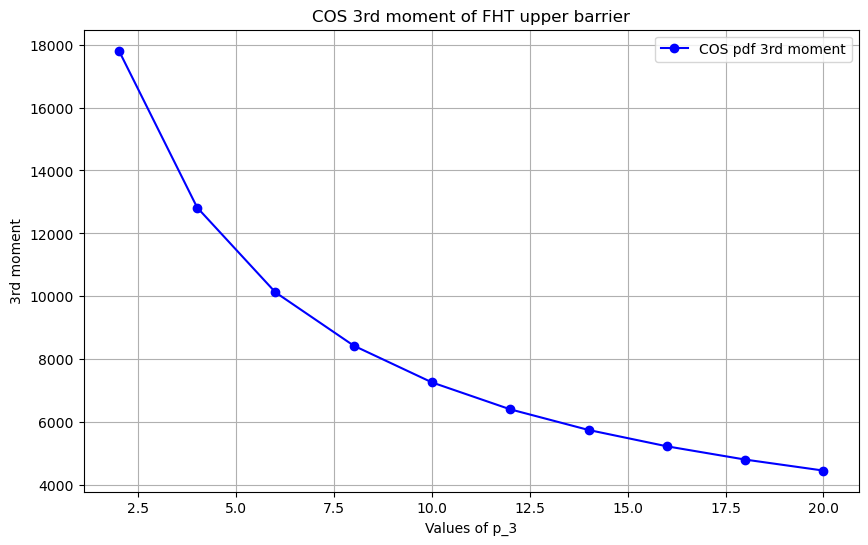

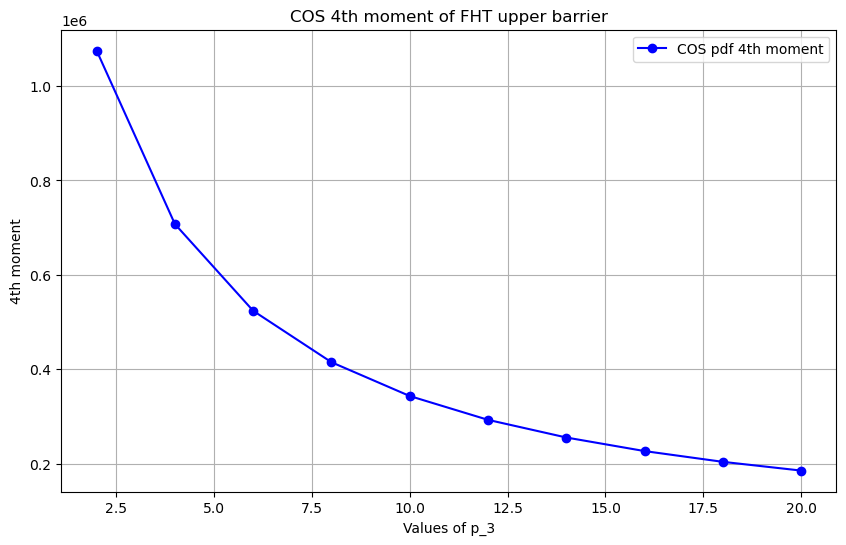

In [31]:
# testing positive values of p_3 for third, fourth moment for upper barrier


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.35
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = 1  # Initial value, will be changed
p_2 = 0.5
p_3 = 1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used
"""
b = 8.
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p3):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / p_1
    elif degree == 2:
        return 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*current_p3))
        q = p**3 + (p_2*p_1 - 3*current_p3*(p_0-x)) / (6*current_p3**2)
        r = p_1/(3*current_p3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p3, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - inv_poly(a, degree, current_p3)) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*(inv_poly(a, degree, current_p3) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def moment3_moment4():
    p_3_values = np.arange(2, 22, 2)
    p_3_values = p_3_values[p_3_values != 0]  # Remove zero to avoid division by zero
    moments3 = []
    moments4 = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_3_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        moment3 = np.trapz(x**3*f_X, x)
        moments3.append(moment3)
        moment4 = np.trapz(x**4*f_X, x)
        moments4.append(moment4)
        

    return p_3_values, moments3, moments4

p_3_values, COS_moments3, COS_moments4 = moment3_moment4()
print(p_3_values)
print(COS_moments3)
print(COS_moments4)
    


plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_moments3, 'b-o', label='COS pdf 3rd moment')
plt.xlabel("Values of p_3")
plt.ylabel("3rd moment")
plt.title("COS 3rd moment of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_moments4, 'b-o', label='COS pdf 4th moment')
plt.xlabel("Values of p_3")
plt.ylabel("4th moment")
plt.title("COS 4th moment of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()



[ 2  4  6  8 10 12 14 16 18 20]
[48724.324737208386, 25097.93164981336, 16857.140629392314, 12743.626132120162, 10292.33536452798, 8668.210102468267, 7513.47767412822, 6650.142562185882, 5979.927325226961, 5444.226811346316]
[3803969.91915759, 1659118.5203034924, 1001772.0993981452, 701866.8087388773, 534880.8989282333, 430050.6193440119, 358750.90239679295, 307402.131766901, 268803.6407523301, 238809.31659481823]


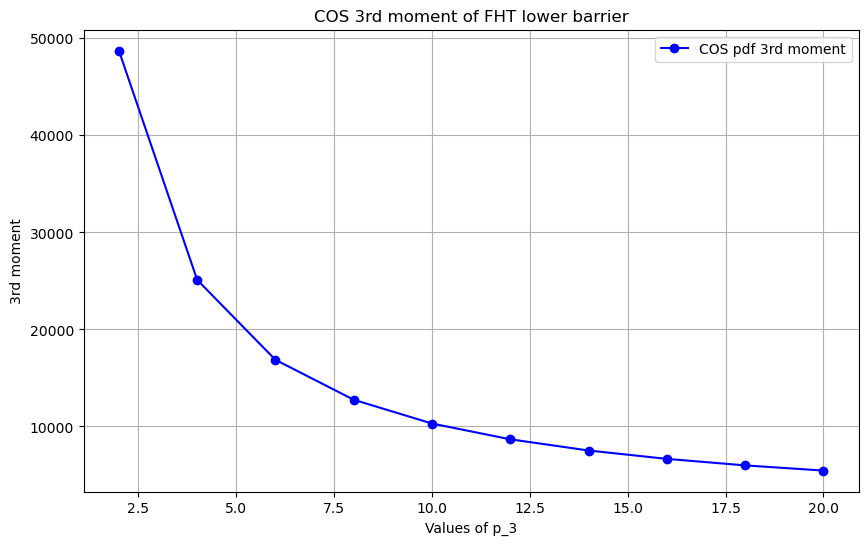

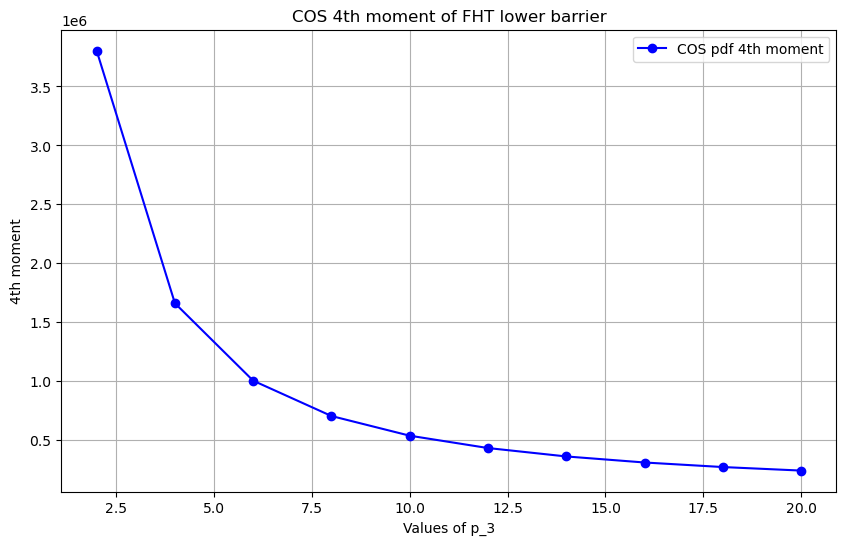

In [47]:
# testing positive values of p_3 for third, fourth moment for lower barrier


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.35
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = 1  # Initial value, will be changed
p_2 = 0.5
p_3 = 1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used

b = 1.65
"""
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p3):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / p_1
    elif degree == 2:
        return 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*current_p3))
        q = p**3 + (p_2*p_1 - 3*current_p3*(p_0-x)) / (6*current_p3**2)
        r = p_1/(3*current_p3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p3, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - (2*x_0 - inv_poly(b, degree, current_p3))) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*((2*x_0 - inv_poly(b, degree, current_p3)) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def moment3_moment4():
    p_3_values = np.arange(2, 22, 2)
    p_3_values = p_3_values[p_3_values != 0]  # Remove zero to avoid division by zero
    moments3 = []
    moments4 = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_3_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        moment3 = np.trapz(x**3*f_X, x)
        moments3.append(moment3)
        moment4 = np.trapz(x**4*f_X, x)
        moments4.append(moment4)
        

    return p_3_values, moments3, moments4

p_3_values, COS_moments3, COS_moments4 = moment3_moment4()
print(p_3_values)
print(COS_moments3)
print(COS_moments4)
    


plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_moments3, 'b-o', label='COS pdf 3rd moment')
plt.xlabel("Values of p_3")
plt.ylabel("3rd moment")
plt.title("COS 3rd moment of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_moments4, 'b-o', label='COS pdf 4th moment')
plt.xlabel("Values of p_3")
plt.ylabel("4th moment")
plt.title("COS 4th moment of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()



[-20 -18 -16 -14 -12 -10  -8  -6  -4  -2]
[4445.259002611367, 4795.743140710676, 5218.161076738851, 5737.9971621357345, 6394.5528868031115, 7251.8441641727695, 8421.784600860366, 10119.594569722476, 12819.591481670392, 17815.99447330844]
[185104.07451583465, 203598.5938344994, 226393.5742463359, 255160.06382280614, 292546.82921550487, 343004.523263647, 414597.0686602679, 523496.50088473805, 707193.8779598756, 1074720.926635373]


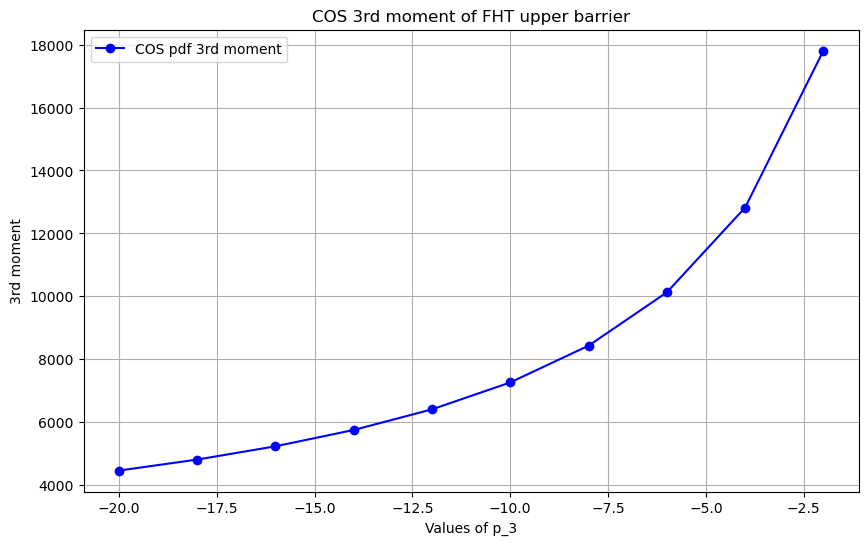

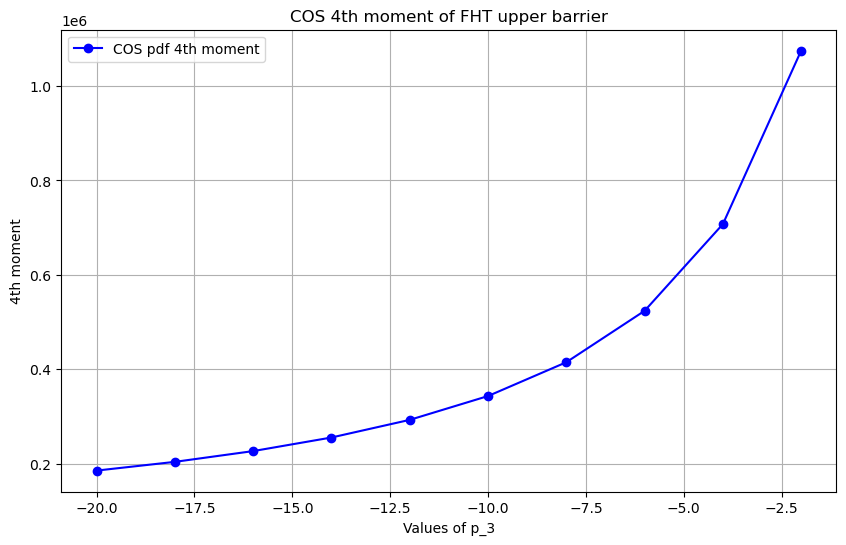

In [35]:
# testing negative values of p_3 for third, fourth moment for upper barrier


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.35
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = -1  # Initial value, will be changed
p_2 = 0.5
p_3 = 1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used

b = 1.65
"""
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p3):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / p_1
    elif degree == 2:
        return 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*current_p3))
        q = p**3 + (p_2*p_1 - 3*current_p3*(p_0-x)) / (6*current_p3**2)
        r = p_1/(3*current_p3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p3, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - (2*x_0 - inv_poly(a, degree, current_p3))) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*((2*x_0 - inv_poly(a, degree, current_p3)) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def moment3_moment4():
    p_3_values = np.arange(-20, 0, 2)
    p_3_values = p_3_values[p_3_values != 0]  # Remove zero to avoid division by zero
    moments3 = []
    moments4 = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_3_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        moment3 = np.trapz(x**3*f_X, x)
        moments3.append(moment3)
        moment4 = np.trapz(x**4*f_X, x)
        moments4.append(moment4)
        

    return p_3_values, moments3, moments4

p_3_values, COS_moments3, COS_moments4 = moment3_moment4()
print(p_3_values)
print(COS_moments3)
print(COS_moments4)
    


plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_moments3, 'b-o', label='COS pdf 3rd moment')
plt.xlabel("Values of p_3")
plt.ylabel("3rd moment")
plt.title("COS 3rd moment of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_moments4, 'b-o', label='COS pdf 4th moment')
plt.xlabel("Values of p_3")
plt.ylabel("4th moment")
plt.title("COS 4th moment of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()



[-20 -18 -16 -14 -12 -10  -8  -6  -4  -2]
[5444.226811346316, 5979.927325226961, 6650.142562185882, 7513.47767412822, 8668.210102468267, 10292.33536452798, 12743.626132120162, 16857.140629392314, 25097.93164981336, 48724.324737208386]
[238809.31659481823, 268803.6407523301, 307402.131766901, 358750.90239679295, 430050.6193440119, 534880.8989282333, 701866.8087388773, 1001772.0993981452, 1659118.5203034924, 3803969.91915759]


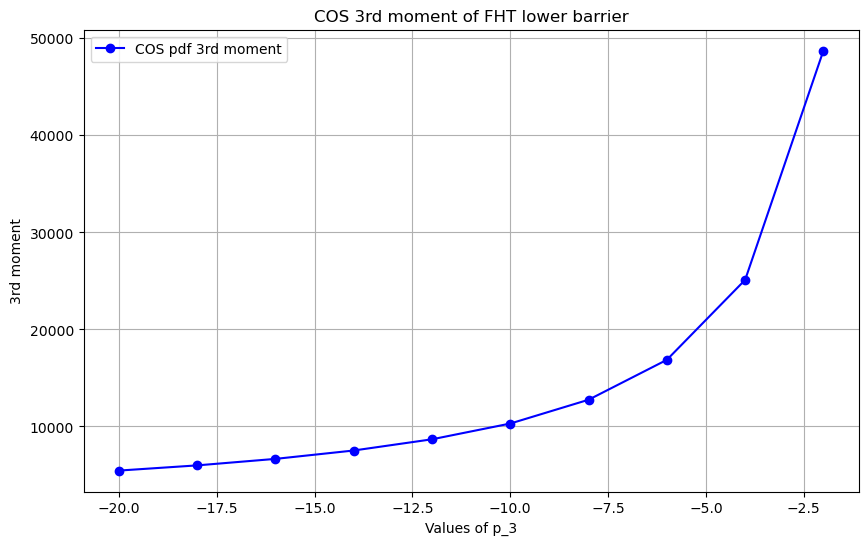

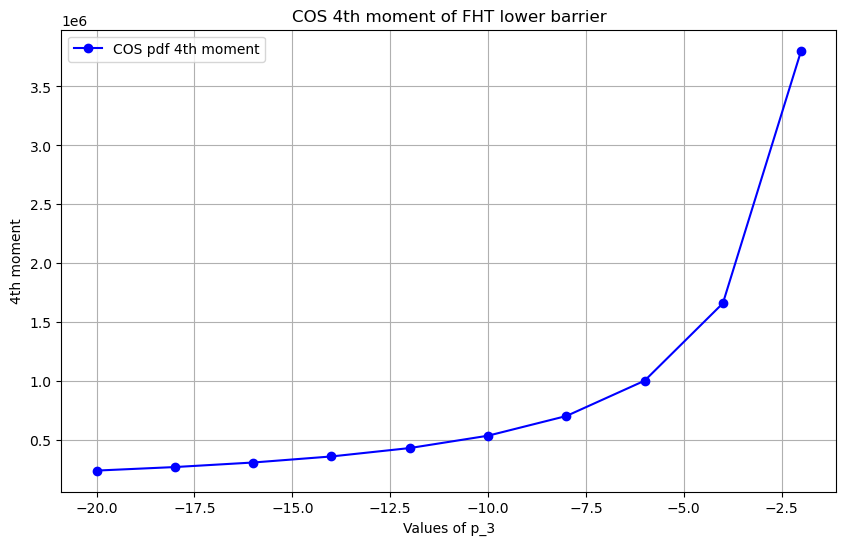

In [49]:
# testing negative values of p_3 for third, fourth moment for upper barrier


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.35
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = -1  # Initial value, will be changed
p_2 = 0.5
p_3 = 1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used

b = 1.65
"""
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p3):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / p_1
    elif degree == 2:
        return 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*current_p3))
        q = p**3 + (p_2*p_1 - 3*current_p3*(p_0-x)) / (6*current_p3**2)
        r = p_1/(3*current_p3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p3, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - (inv_poly(b, degree, current_p3))) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*((inv_poly(b, degree, current_p3)) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def moment3_moment4():
    p_3_values = np.arange(-20, 0, 2)
    p_3_values = p_3_values[p_3_values != 0]  # Remove zero to avoid division by zero
    moments3 = []
    moments4 = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_3_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        moment3 = np.trapz(x**3*f_X, x)
        moments3.append(moment3)
        moment4 = np.trapz(x**4*f_X, x)
        moments4.append(moment4)
        

    return p_3_values, moments3, moments4

p_3_values, COS_moments3, COS_moments4 = moment3_moment4()
print(p_3_values)
print(COS_moments3)
print(COS_moments4)
    


plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_moments3, 'b-o', label='COS pdf 3rd moment')
plt.xlabel("Values of p_3")
plt.ylabel("3rd moment")
plt.title("COS 3rd moment of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_3_values, COS_moments4, 'b-o', label='COS pdf 4th moment')
plt.xlabel("Values of p_3")
plt.ylabel("4th moment")
plt.title("COS 4th moment of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

